Q)Use the random sampling, empirical distribution, sample comparison, bootstrap, hypothesis testing as well as A/B testing we discussed in the class to analyze the income gap between female and male employees.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib
matplotlib.use('Agg')
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')
import math

extracting previously saved data from csv into runtime

In [0]:
dataset = Table.read_table('../content/drive/My Drive/Colab Notebooks/Assignments_5502/4/incomes.csv')

In [10]:
dataset.group('gender')

gender,count
Female,1627
Male,9256


Finding the ratio of male to female to find the sample_proportion

In [0]:
population_size = dataset.num_rows
female_ratio = round((dataset.where('gender', are.equal_to('Female')).num_rows)/population_size, 1)
male_ratio = round((dataset.where('gender', are.equal_to('Male')).num_rows)/population_size, 1)


Q) Select a sample from the population. Make sure your sample include 500 employees selected from the population, and consider how to ensure the sampling strategy is fair since the datasets include overwhelmed male employees than female employees (1 point).

In [0]:
def generate_sample():
  num_female_rows_in_Sample = int(female_ratio*500)
  num_male_rows_in_Sample = int(male_ratio*500)
  female_dataset = dataset.where('gender', are.equal_to('Female'))
  female_sample = female_dataset.sample(num_female_rows_in_Sample)
  male_dataset = dataset.where('gender', are.equal_to('Male'))
  male_sample = male_dataset.sample(num_male_rows_in_Sample)
  sample = female_sample.append(male_sample)
  return sample

In [68]:
generate_sample()

gender,appx_income
Female,65000
Female,45000
Female,15000
Female,15000
Female,25000
Female,25000
Female,15000
Female,35000
Female,55000
Female,95000


Q) Define test statistic, null hypothesis and alternative hypothesis (1 point).

In [13]:
medians_table = dataset.group('gender', np.median)
medians_table

gender,appx_income median
Female,45000
Male,55000


**Test statistic** here is the income_gap interms of median income values which is 10000 as observed from the population

In [31]:
medians = medians_table.column(1)
pop_income_gap = medians.item(1) - medians.item(0)
pop_income_gap

10000.0

**Null Hypotheses**:  In the population, Income gap between Male employees and Female employees is at most $10,000. If there is a significant difference observed, it is due to chance.

**Alternate Hypotheses:** In the population, Male employees have greater median income when compared to the Female employees. The difference in incomes is more than $10,000


Q) Draw the income histogram for the sample, calculate the median income of the sample, and draw a red
dot and a yellow dot of the female median income and male median income of the population, respectively,
in the histogram (1 point).

In [15]:
original_sample = generate_sample()
sample_medians_table = original_sample.group('gender', np.median)
sample_medians_table

gender,appx_income median
Female,45000
Male,55000


In [16]:
sample_medians = sample_medians_table.column(1)
sample_observed_gap = sample_medians.item(1) - sample_medians.item(0)
sample_observed_gap

10000.0

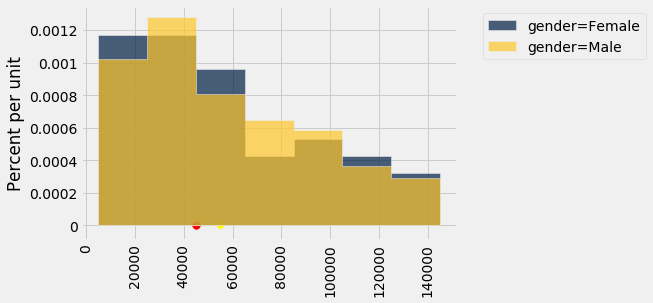

In [17]:
original_sample.hist('appx_income', group='gender', bins = range(5000, 150000, 20000))
plt.scatter(sample_medians.item(0), 0, color='red', s=60)
plt.scatter(sample_medians.item(1), 0, color='yellow', s=40)

Q) Draw the histogram of the test statistic of the sample, and draw a red dot to show the corresponding test statistic of the population (e.g. the difference of the median incomes between female and male employees) in the diagram (1 point).

In [0]:
def difference_of_medians(table, label, group_label):
    reduced = table.select(label, group_label)
    medians_table = reduced.group(group_label, np.median)
    medians = medians_table.column(1)
    return medians.item(1) - medians.item(0)

A/B testing. Empirical distribution of Median income gap

In [0]:
def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(with_replacement = False).column(0)
    shuffled_table = table.with_column('Shuffled Label', shuffled_labels)
    return difference_of_medians(shuffled_table, label, 'Shuffled Label')    

In [0]:
sample_income_gap = one_simulated_difference(original_sample, 'appx_income', 'gender')
differences = make_array()
repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference(original_sample, 'appx_income', 'gender')
    differences = np.append(differences, new_difference)                               

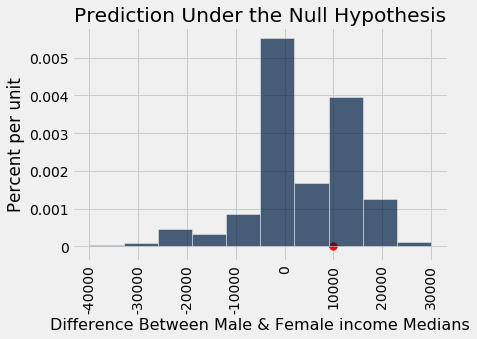

In [25]:
Table().with_column('Difference Between Male & Female income Medians', differences).hist()
plt.scatter(sample_observed_gap, 0, color='red', s=60)
plt.title('Prediction Under the Null Hypothesis');

Finding the empirical P-value based on A/B testing

In [80]:
empirical_P = np.count_nonzero(differences <= sample_observed_gap) / 5000
print('P-value caluclated from A/B testing is:', empirical_P*100, 'which is the percentage of values less than or equal to $10,000')

P-value caluclated from A/B testing is: 85.08 which is the percentage of values less than or equal to $10,000


Q) Write a procedure to use bootstrap to produce at least 5000 samples (1 point).

In [0]:
def generate_bootstrap_samples(table, replications):
    bootstrap_medians_diff = make_array()
    for i in np.arange(replications):
        bootstrap_sample = table.sample()
        resampled_median_diff = difference_of_medians(bootstrap_sample, 'appx_income', 'gender')
        bootstrap_medians_diff = np.append(bootstrap_medians_diff, resampled_median_diff)
    return bootstrap_medians_diff

In [0]:
bstrap_medians_diff = generate_bootstrap_samples(original_sample, 5000)

Draw the histogram of the test statistic of the bootstrap samples (1 point).

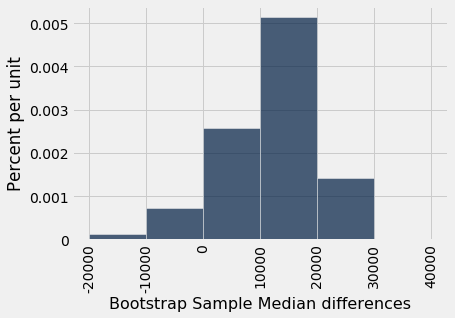

In [57]:
Table().with_column('Bootstrap Sample Median differences', bstrap_medians_diff).hist(bins = range(-20000, 50000, 10000))

Finding the empirical P-value based on A/B testing

In [79]:
bstrp_samp_p_value = np.count_nonzero( bstrap_medians_diff<= sample_observed_gap) / 5000
print('P-value caluclated from Bootstrap samples is:', bstrp_samp_p_value*100, 'which is the percentage of values less than or equal to $10,000')

P-value caluclated from Bootstrap samples is: 82.0 which is the percentage of values less than or equal to $10,000


Q) Define confidence interval and P-value to validate the hypothesis you defined (2 points).

Defining cutoff value for the P-value as 5% hence confidence interval of 95%

In [50]:
left = percentile(2.5, bstrap_medians_diff)
right = percentile(97.5, bstrap_medians_diff)
print('95% confidence interval is: ', make_array(left,right))

95% confidence interval is:  [-10000.  20000.]


In [78]:
if (bstrp_samp_p_value >= right):
  print('Empirical distribution supports null hypotheses that income gap between male and female employees is atmost $10,000 as the emperical P-value caluclated is equal to or greater than 95%')
else :
  print('Empirical distribution supports alternate hypotheses that income gap between male and female employees is greater than $10,000 as the emperical P-value caluclated is less than 95%')

Empirical distribution supports alternate hypotheses that income gap between male and female employees is greater than $10,000 as the emperical P-value caluclated is less than 95%


Empirical histogram of the 5,000 bootstrapped means is shown below, along with the 95% confidence interval for the population mean.

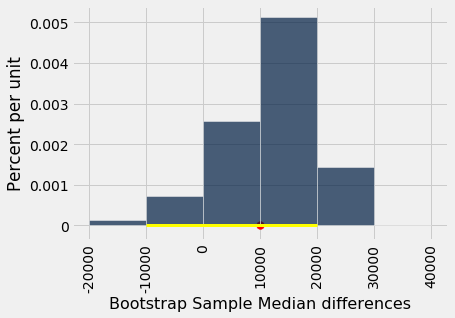

In [58]:
Table().with_column('Bootstrap Sample Median differences', bstrap_medians_diff).hist(bins = range(-20000, 50000, 10000))
plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=3);
plt.scatter(pop_income_gap, 0, color='red', s=60);

Validation of Hypotheses

In [82]:
if (bstrp_samp_p_value >= right):
  print('we accept null hypotheses as Empirical P-value of: ', (bstrp_samp_p_value*100), '% more than the defined Empirical P-value of 95%')
else :
  print('we reject null hypotheses as Empirical P-value of: ', (bstrp_samp_p_value*100), '% is less than the defined Empirical P-value of 95%')

we reject null hypotheses as  0.82 % income gap values are out of the given confidence level
